In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load JSON data
with open("/content/dataset.json", "r") as file:
    data = json.load(file)

# Convert lists to NumPy arrays
SC = np.array(data["Spectral_Centroid"], dtype=np.float64)
SE = np.array(data["Spectral_Entropy"], dtype=np.float64)
SF = np.array(data["Spectral_Flatness"], dtype=np.float64)
HNR = np.array(data["Harmonic_To_Noise_Ratio"], dtype=np.float64)

SC_sd = np.array(data["Spectral_Centroid_Standard_Deviation"], dtype=np.float64)
SE_sd = np.array(data["Spectral_Entropy_Standard_Deviation"], dtype=np.float64)
SF_sd = np.array(data["Spectral_Flatness_Standard_Deviation"], dtype=np.float64)
HNR_sd = np.array(data["HNR_Standard_Deviation"], dtype=np.float64)

bird = np.array(data["bird"])  # Target variable

# Normalization function
def norm(arr, mi, mx):
    normalized = (arr - mi)  / (mx - mi)
    return np.clip(normalized, 0, 100)



X = np.column_stack((
   norm(SC, 50, 5000), norm(SE, 0, 5), norm(SF, 0, 1), norm(HNR, -15, 15),
   norm(SC_sd, 0, 5000), norm(SE_sd, 0, 5), norm(SF_sd, 0, 0.5), norm(HNR_sd, 0, 15)
))

#X = np.column_stack((SC, SE, SF, HNR, SC_sd, SE_sd, SF_sd, HNR_sd))

y = bird.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Split into training and test sets

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svm_clf = SVC()

# Define hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "gamma": ["scale", "auto", 0.01, 0.1, 1],  # Kernel coefficient
    "kernel": ["rbf", "linear", "poly", "sigmoid"]  # Different kernels
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_svm = grid_search.best_estimator_

# Predict on test set
y_pred = best_svm.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Hyperparameters: {grid_search.best_params_}")
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Test Accuracy: 0.7962

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       154
         1.0       0.79      0.68      0.73       106

    accuracy                           0.80       260
   macro avg       0.80      0.78      0.78       260
weighted avg       0.80      0.80      0.79       260


Confusion Matrix:
[[135  19]
 [ 34  72]]


In [ ]:
m=lambda a:[a.min(),a.max()]

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


class SelfAttention(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.attention_weights  = torch.nn.Parameter(torch.randn(n, n) * 0.1)
        self.classifier_weights = torch.nn.Parameter(torch.randn(n) * 0.1)

    def forward(self, x):
        attention_scores = x @ self.attention_weights
        return torch.softmax(attention_scores @ self.classifier_weights, dim=-1)

class AttentionClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.attention_mu    = SelfAttention(4)
        self.attention_sigma = SelfAttention(4)
        self.weight_factors  = torch.nn.Parameter(torch.randn(2))

    def forward(self, x):
        mu    = self.attention_mu(x[:, :4])
        sigma = self.attention_sigma(x[:, 4:])

        # weighted sum
        out = mu * self.weight_factors[0] + sigma * self.weight_factors[1]
        return torch.sigmoid(out).unsqueeze(1)





# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42, stratify=y)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

batch_size     = 16
train_dataset  = TensorDataset(X_train_tensor, y_train_tensor)
train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize Model, Loss, Optimizer#model     = AttentionClassifier().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
best_loss = float("inf")

epochs = 5500
best_model_state = None
best_loss = float('inf')  # Initialize with a high loss
loss_history = []
history_window = 30  # Check over a longer history window

In [ ]:
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # Track loss
    loss_value = loss.item()
    loss_history.append(loss_value)

    # Save best model
    if loss_value < best_loss:
        best_loss = loss_value
        best_model_state = model.state_dict()

    # Check moving average trend over a longer history window
    if len(loss_history) >= history_window:
        recent_losses = loss_history[-history_window:]
        if all(recent_losses[i] > recent_losses[i - 1] for i in range(1, history_window)):
            print(f"Stopping early at epoch {epoch+1} due to increasing loss trend.")
            break

    # Print progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value:.4f}")

# Load the best model weights


Epoch 1/5500, Loss: 0.6930
Epoch 51/5500, Loss: 0.6916
Epoch 101/5500, Loss: 0.6847
Epoch 151/5500, Loss: 0.6550
Epoch 201/5500, Loss: 0.6809
Epoch 251/5500, Loss: 0.6650
Epoch 301/5500, Loss: 0.6144
Epoch 351/5500, Loss: 0.6165
Epoch 401/5500, Loss: 0.6101
Epoch 451/5500, Loss: 0.6199
Epoch 501/5500, Loss: 0.5857
Epoch 551/5500, Loss: 0.5814
Epoch 601/5500, Loss: 0.5856
Epoch 651/5500, Loss: 0.5752
Epoch 701/5500, Loss: 0.5670
Epoch 751/5500, Loss: 0.5882
Epoch 801/5500, Loss: 0.5711
Epoch 851/5500, Loss: 0.6918
Epoch 901/5500, Loss: 0.5856
Epoch 951/5500, Loss: 0.5293
Epoch 1001/5500, Loss: 0.5715
Epoch 1051/5500, Loss: 0.5825
Epoch 1101/5500, Loss: 0.5380
Epoch 1151/5500, Loss: 0.6286
Epoch 1201/5500, Loss: 0.6601
Epoch 1251/5500, Loss: 0.5331
Epoch 1301/5500, Loss: 0.5644
Epoch 1351/5500, Loss: 0.5714
Epoch 1401/5500, Loss: 0.7071
Epoch 1451/5500, Loss: 0.5987
Epoch 1501/5500, Loss: 0.5676
Epoch 1551/5500, Loss: 0.4989
Epoch 1601/5500, Loss: 0.5425
Epoch 1651/5500, Loss: 0.4837
Epo

In [ ]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model weights with lowest recorded loss: {best_loss:.4f}")

Loaded best model weights with lowest recorded loss: 0.2699


Optimal Threshold: 0.5002

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       292
         1.0       0.75      0.75      0.75       202

    accuracy                           0.79       494
   macro avg       0.79      0.79      0.79       494
weighted avg       0.79      0.79      0.79       494


Confusion Matrix:
[[240  52]
 [ 50 152]]


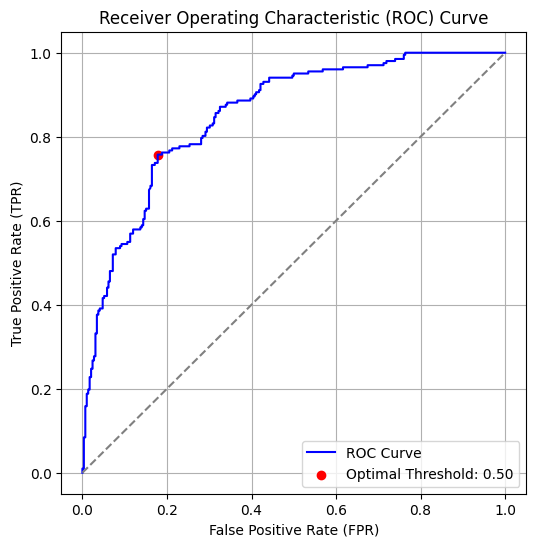

In [ ]:
model.eval()
with torch.no_grad():
    # Get probability predictions (move to CPU before numpy conversion)
    y_pred_prob = model(X_test_tensor).cpu().numpy().flatten()  # Flatten to ensure 1D shape

    # Compute ROC curve
    y_test_np = y_test_tensor.cpu().numpy().flatten()  # Ensure 1D
    fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_prob)

    # Compute the optimal threshold (Youden’s J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Apply the optimal threshold
    y_pred_labels = (y_pred_prob > optimal_threshold).astype(float)

    # Evaluate performance
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_labels))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_np, y_pred_labels))

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label="ROC Curve", color="blue")
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold: {optimal_threshold:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for name, param in model.named_parameters():
    print(name, param.data.cpu().numpy())

weight_factors [-7.2962785  5.087236 ]
attention_mu.attention_weights [[-1.236485    1.2841476   1.1996638   1.2770605 ]
 [ 0.25393116 -0.10121036 -0.08832756 -0.03427489]
 [ 0.02474513  0.19741581  0.17117405 -0.14574401]
 [-0.16988271  0.10872957  0.22121006  0.13842374]]
attention_mu.classifier_weights [ 1.446442  -1.2041183 -1.0666766 -1.2597078]
attention_sigma.attention_weights [[ 0.6357017  -0.7414155   0.53915507 -0.62237227]
 [ 0.10897908 -0.18616886 -0.09619793  0.02540057]
 [ 0.21302684 -0.25590244  0.334873   -0.21258917]
 [ 0.25944644 -0.2860238   0.14900288 -0.33277774]]
attention_sigma.classifier_weights [ 0.39374897 -0.42585838  0.58339256 -0.55304706]


In [ ]:


def print_c_weights(model, filename="/content/weights.h"):
    with open(filename, "w") as f:
        f.write('#include "../../headers/ml/weights.h"\n\n')

        for name, param in model.named_parameters():
            data = param.data.cpu().numpy()

            # Check if the weights are 1D or 2D
            if len(data.shape) == 2:
                # Flatten the 2D weight matrix into a 1D array
                f.write(f"float {name.replace('.', '_')}[{data.size}] = {{\n")
                f.write(", ".join(f"{val:.7f}" for val in data.flatten()))
                f.write("};\n\n")
            elif len(data.shape) == 1:
                # Directly write the 1D array
                f.write(f"float {name.replace('.', '_')}[{data.shape[0]}] = {{")
                f.write(", ".join(f"{val:.7f}" for val in data))
                f.write("};\n\n")

        # Example threshold value (adjust accordingly)
        f.write(f"float PRED_TH={optimal_threshold:.4};\n")

print_c_weights(model)